# MNDO error analysis of a simple quantum chemistry calculation

The main purpose of this notebook is to analyze the modified neglect of diatomic overlap (MNDO) model approximations that semiempirical quantum chemistry calculations have been relying on for the last forty years. We will examine this approximation in the context of a very simple and very crude quantum chemistry calculation: a helium dimer at the Hartree-Fock level of theory with a single Gaussian atomic orbital on each atom. Quantitatively, this calculation is terrible and produces completely worthless numerical results. Qualitatively, it retains the correct basic physics and phenomenology of a calculation with a more converged basis set. By producing results with a simple analytical form, we can use this example to better understand some of the enduring consequences of the MNDO approximation that have arguably limited the accuracy, success, and popularity of semiempirical quantum chemistry.

As a point of reference, we begin by calculating the potential energy surface for a helium dimer in a well-converged basis set using Hartree-Fock (HF) theory, density functional theory (DFT) in the local density approximation (LDA), and an accurate reference of high-level coupled-cluster theory (CCSD(T)):

In [2]:
import psi4
import numpy as np

bohr_to_angstrom = 0.529177210903 # Psi4 uses Angstroms, this notebook uses Bohr
min_distance = 2.0
max_distance = 8.0
num_distance = 31
distance_list = np.linspace(min_distance, max_distance, num = num_distance)
hf_energy_list = []
lda_energy_list = []
ref_energy_list = []

monomer = psi4.geometry(f'''He''')
hf_energy0 = psi4.energy('hf/aug-cc-pvqz', molecule=monomer)
lda_energy0 = psi4.energy('svwn/aug-cc-pvqz', molecule=monomer)
ref_energy0 = psi4.energy('ccsd(t)/aug-cc-pvqz', molecule=monomer)
print('atom', hf_energy0, lda_energy0, ref_energy0)

for distance in distance_list:
    dimer = psi4.geometry(f'''He\n --\n He 1 {distance * bohr_to_angstrom}''')
    hf_energy_list.append(psi4.energy('hf/aug-cc-pvqz', bsse_type='cp', molecule=dimer))
    lda_energy_list.append(psi4.energy('svwn/aug-cc-pvqz', bsse_type='cp', molecule=dimer))
    ref_energy_list.append(psi4.energy('ccsd(t)/aug-cc-pvqz', bsse_type='cp', molecule=dimer))
    print(distance, hf_energy_list[-1], lda_energy_list[-1], ref_energy_list[-1])

atom -2.861544913827288 -2.8720903231012 -2.9025335995465493
2.0 0.12077101786066446 0.10528749052211595 0.11488124191248517
2.2 0.07871909646760766 0.06687070590027311 0.07429068355965729
2.4 0.05104785465927719 0.04180154890350263 0.04770639835849089
2.6 0.03294664629622268 0.02562660342970613 0.030411376752684127
2.8 0.021169746289516844 0.015319458909753614 0.01923417540105543
3.0 0.013547351360985616 0.008846435399549435 0.012059909086239884
3.2 0.008638672359964517 0.004853293618801935 0.007487873308865467
3.4000000000000004 0.005492473974560319 0.002445506898927974 0.004596393305014601
3.6 0.00348429652638238 0.0010371117927840956 0.002782875706943244
3.8 0.0022067497017488336 0.00024802515697963656 0.0016558663102443916
4.0 0.0013958893156065244 -0.0001653429171168952 0.0009627415929847061
4.2 0.0008819264477084587 -0.00035689801049354486 0.0005416154818362884
4.4 0.0005563539710990995 -0.00042229132127236113 0.00028950943200456436
4.6 0.00035017037879381263 -0.0004198235642984

For small interatomic distances, interatomic potentials are always strongly repulsive:

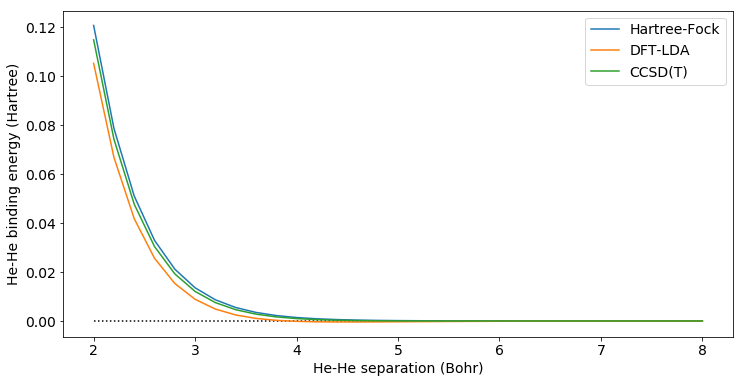

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["font.size"] = 14

plt.plot(distance_list, [0] * len(distance_list), linestyle=':', color='black')
plt.plot(distance_list, hf_energy_list, label='Hartree-Fock')
plt.plot(distance_list, lda_energy_list, label='DFT-LDA')
plt.plot(distance_list, ref_energy_list, label='CCSD(T)')

plt.xlabel('He-He separation (Bohr)')
plt.ylabel('He-He binding energy (Hartree)')
plt.legend()
plt.show()

All of these theories produce the same qualitative behavior on this high energy scale with relatively minor quantitative differences. However, if we zoom into the smaller energy scale relevant to large interatomic distances, then we see some important qualitative differences:

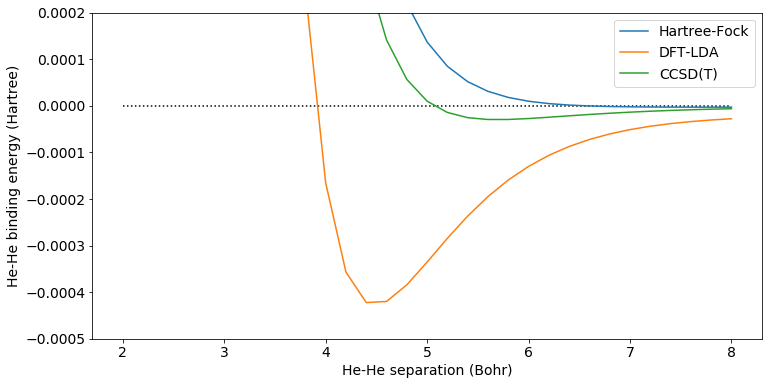

In [7]:
plt.plot(distance_list, [0] * len(distance_list), linestyle=':', color='black')
plt.plot(distance_list, hf_energy_list, label='Hartree-Fock')
plt.plot(distance_list, lda_energy_list, label='DFT-LDA')
plt.plot(distance_list, ref_energy_list, label='CCSD(T)')

plt.xlabel('He-He separation (Bohr)')
plt.ylabel('He-He binding energy (Hartree)')
plt.legend()

plt.ylim(-0.0005,0.0002)
plt.show()

The CCSD(T) reference binding energy is close to the experimental value ($\approx 3.5 \times 10^{-5}$ Ha), but the DFT-LDA value is ten times too large and one bohr too close. Also, the DFT-LDA attraction is a contact interaction that decays exponentially with distance rather than the conventional $R^{-6}$ algebraic decay of dispersion energies. The generic overbinding of DFT-LDA is a well-known problem resulting from its simple local model of exchange and correlation effects. We will soon see that MNDO approximations causes qualitatively similar errors but of an even larger size.

We begin by specifying our elementary basis functions and matrix elements. For simplicity, we will use a single normalized Gaussian to approximate the 1s orbitals on a He atom,

$$ \begin{align} \psi(\vec{r}) &= g(x) g(y) g(z) \\
   g(x) &= {\pi}^{-1/4} r_0^{-1/2} \exp(-x^2/ (2 r_0^2))
    \end{align} $$
    
All of our orbitals will have a common width $r_0$, which we will tune to minimize the HF energy of an isolated He atom. We will refer to the non-orthogonal atomic orbitals on the two atoms of the dimer as 'A' and 'B'. The purely electronic one-body matrix elements are the overlap and kinetic energy between two orbitals,

$$ \begin{align} \langle A | B \rangle &= \int \psi(\vec{r}) \, \psi(\vec{r} + d_0 \hat{x}) \, d\vec{r} = \exp(- d_0^2/ (4 r_0^2) ) \\
 \langle A |\hat{h}| B \rangle &= \frac{1}{2}\int  \vec{\nabla} \psi(\vec{r}) \cdot \vec{\nabla} \psi(\vec{r} + d_0 \hat{x}) \, d\vec{r} = \langle A | B \rangle \, ( 6 - d_0^2 / r_0^2 ) / (8 r_0^2) ,
   \end{align} $$
   
which depend on the dimer separation $d_0$. The AA matrix elements are the same as the AB matrix elements with $d_0 = 0$. Then there are all of the Coulomb matrix elements between ions and electrons,

$$ \begin{align} E_C (d,r) &= \mathrm{erf}(d/r)/d \\
 E_{\mathrm{ion}} &= 4 \, E_C(d_0, 0) \\
 \langle A | \hat{v}_B | A \rangle &= - 2 \, E_C(d_0, r_0) \\
 \langle A | \hat{v}_A | B \rangle &=  - 2 \, E_C(d_0/2, r_0) \, \langle A | B \rangle \\
 (AA|BB) &= E_C(d_0, \sqrt{2} r_0) \\
 (AA|AB) &= E_C(d_0/2, \sqrt{2}r_0) \, \langle A | B \rangle \\
 (AB|AB) &= E_C(0, \sqrt{2}r_0) \, \langle A | B \rangle^2,
\end{align} $$

which all utilize the standard machinery of Gaussian integrals in quantum chemistry. These Coulombic terms decompose into contributions from a Coulomb energy with an effective distance and width and orbital overlap factors. We can then attempt to ascribe errors to specific components of these decompositions.

In [141]:
def overlap(distance, width):
    return np.exp( -(distance / (2.0 * width))**2 )

def kinetic(distance, width):
    return overlap(distance, width) * (6.0 - (distance/width)**2 )/(8.0*width**2)

def coulomb(distance, width):
    if distance > 1e6*width:
        return 1.0 / distance
    elif distance > 1e-6*width:
        return np.erf(distance/width) / distance
    else: # Taylor series expansion
        x = (distance/width)**2
        return (1.0 - x/3.0 + x**2/10.0 - x**3/42.0) * (2.0/np.sqrt(np.pi)) / width

# lazy shorthand functions
def E_ion(): return 4.0*coulomb(d0, 0.0)
def AB(): return overlap(d0, r0)
def h_AA(): return kinetic(0.0, r0)
def h_AB(): return kinetic(d0, r0)
def vA_AA(): return -2.0*coulomb(0.0, r0)
def vB_AA(): return -2.0*coulomb(d0, r0)
def vA_AB(): return -2.0*coulomb(0.5*d0, r0)*overlap(d0, r0)
def AAAA(): return coulomb(0.0, np.sqrt(2.0)*r0)
def AABB(): return coulomb(d0, np.sqrt(2.0)*r0)
def AAAB(): return coulomb(0.5*d0, np.sqrt(2.0)*r0)*overlap(d0, r0)
def ABAB(): return coulomb(0.0, np.sqrt(2.0)*r0)*overlap(d0, r0)**2

Before we consider the dimer, we will optimize the orbital width to minimize the HF energy of the isolated Helium atom,

$$ E_{\mathrm{atom}} = 2 \langle A | \hat{h} | A \rangle + 2 \langle A | \hat{v}_A | A \rangle + (AA | AA) $$

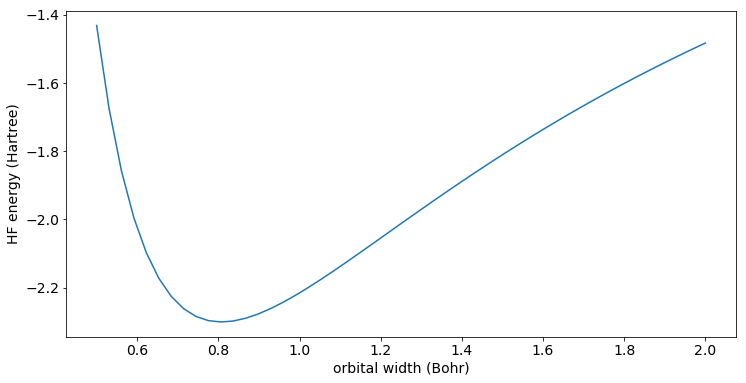

In [77]:
def atom_energy(width):
    global d0, r0
    d0 = 0.0
    r0 = width
    return 2.0*h_AA() + 2.0*vA_AA() + AAAA()

width_list = np.linspace(0.5,2.0,num=50)
energy_list = [atom_energy(width) for width in width_list]

plt.plot(width_list, energy_list)

plt.xlabel('orbital width (Bohr)')
plt.ylabel('HF energy (Hartree)')
plt.show()

We are missing about 0.6 Hartrees of energy from the total energy, and the orbital is strongly contracted relative to  the widest Gaussian (1.26 Bohr) in the STO-3G basis for Helium (an arbitrary but representative comparison). With such large basis set errors, we need to assess the impact of basis set superposition error (BSSE) before continuing our study of NDDO errors. BSSE is usually very small for mean-field methods like HF theory, but here we are dealing with a rather extreme case of basis-set incompleteness.

To assess BSSE errors, we consider an extra Gaussian basis function centered on a ghost atom and hybridize with it to lower the HF energy. We introduce a hybridization parameter $\lambda$ for our modified, normalized orbital A',

$$ |A'\rangle = \frac{|A\rangle + \lambda|B\rangle}{\sqrt{1 + 2 \lambda \langle A | B \rangle + \lambda^2}} . $$

We can substitute A for A' in our $E_{\mathrm{atom}}$ formula and simplify it into 

$$ \begin{align} E'_{\mathrm{atom}}(\lambda) &= 2 \frac{\langle A | \hat{h} | A \rangle + \langle A | \hat{v}_A | A \rangle +  2 \lambda ( \langle A | \hat{h} | B \rangle + \langle A | \hat{v}_A | B \rangle ) + \lambda^2 (\langle A | \hat{h} | A \rangle + \langle A | \hat{v}_B | A \rangle) }{1 + 2 \lambda \langle A | B \rangle + \lambda^2} \\
 & \ \ \ \ + \frac{(1 + \lambda^4) (AA | AA) + 4 (\lambda + \lambda^3) (AA|AB) + 2 \lambda^2 [ (AA|BB) + 2 (AB|AB) ]}{(1 + 2 \lambda \langle A | B \rangle + \lambda^2)^2} .
\end{align} $$

For every distance of interest, we can minimize the energy over the hybridization parameter to calculate the size of the BSSE error:

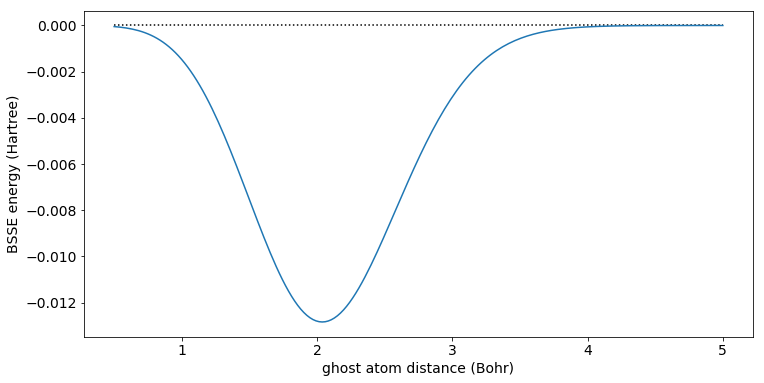

In [186]:
from scipy.optimize import minimize

def atom_energy_bsse(y, distance, width):
    global d0, r0
    d0 = distance
    r0 = width
    denominator = 1.0 + 2.0*y*AB() + y**2
    one_body = 2.0*(h_AA() + vA_AA() + 2.0*y*(h_AB() + vA_AB()) + y**2*(h_AA() + vB_AA()))/denominator
    two_body = ((1+y**4)*AAAA() + 4.0*(y+y**3)*AAAB() + 2.0*y**2*(AABB() + 2.0*ABAB()))/denominator**2
    return one_body + two_body

def atom_energy_min(distance, width):
    minimum = minimize(atom_energy_bsse, 0.0, (distance, width), method='Nelder-Mead',tol=1e-8)
    return atom_energy_bsse(minimum.x, distance, width)

width = 0.8 # approximately the optimal width from the previous figure

distance_list2 = np.linspace(0.5, 5.0, num = 200)
bsse_list = [atom_energy_min(distance, width) - atom_energy(width) for distance in distance_list2]
plt.plot(distance_list2, [0] * len(distance_list2), linestyle=':', color='black')
plt.plot(distance_list2, bsse_list)

plt.xlabel('ghost atom distance (Bohr)')
plt.ylabel('BSSE energy (Hartree)')
plt.show()

BSSE errors are negligible until around 4 Bohr, at which point they produce an energy correction that is $10\times$ larger than the LDA binding energy and $100\times$ larger than the CCSD(T) binding energy of a Helium dimer. Because this is lowering the energy of the isolated atoms, it will contribute to an effective repulsion energy for the BSSE-corrected He dimer. However, if the NDDO error is even larger still, its erroneous attraction may ultimately overwhlem the BSSE repulsive correction and still produce a net attraction between He atoms.

The various MNDO approximations are most naturally described in a basis of symmetrically orthogonalized atomic orbitals. For the He dimer, these orbitals are labeled as $\bar{A}$ and $\bar{B}$,

$$ \begin{align} |\bar{A}\rangle &= w_1 |A\rangle + w_2 |B\rangle \\
|\bar{B}\rangle &= w_2 |A\rangle + w_1 |B\rangle \\
w_1 &= \frac{1}{2\sqrt{1 + \langle A| B\rangle}} + \frac{1}{2 \sqrt{1 - \langle A| B\rangle}} \\
w_2 &= \frac{1}{2\sqrt{1 + \langle A| B\rangle}} - \frac{1}{2 \sqrt{1 - \langle A| B\rangle}} .
\end{align} $$

As with other expressions, we will exploit symmetries and relabel matrix elements ($A \leftrightarrow B$) to merge equivalent matrix elements. We first write the various contributions to the dimer HF energy in the orthogonalized basis,

$$ \begin{align} E_{\mathrm{dimer}} &= E_{\mathrm{ion}} + E_1 + E_{2H} + E_{2X} \\
 E_1 &= 4 \langle \bar{A} | \hat{h} | \bar{A} \rangle + 4 \langle \bar{A} | \hat{v}_A | \bar{A} \rangle + 4 \langle \bar{A} | \hat{v}_B | \bar{A} \rangle \\
 E_{2H} &= 4 (\bar{A} \bar{A} | \bar{A} \bar{A} ) + 4 (\bar{A} \bar{A} | \bar{B} \bar{B} ) \\
 E_{2X} &= - 2 (\bar{A} \bar{A} | \bar{A} \bar{A} ) - 2 (\bar{A} \bar{B} | \bar{A} \bar{B} )
\end{align} $$

where the splitting into Hartree (2H) and Fock-exchange (2X) energy contributions is slightly arbitrary (we include the usual self-energy term for each electronic orbital that cancels between $E_{2H}$ and $E_{2X}$). 

To carry out the dimer HF calculation, we need to again decompose the matrix elements in a transformed basis back into the primary atomic orbital basis,

$$ \begin{align} E_1 &= 4 ( w_1^2 + w_2^2 ) ( \langle A | \hat{h} | A \rangle + \langle A | \hat{v}_A | A \rangle + \langle A | \hat{v}_B | A \rangle )  \\
& \ \ \ \ + 8 w_1 w_2 ( \langle A | \hat{h} | B \rangle + 2 \langle A | \hat{v}_A | B \rangle ) \\
 E_{2H} &= 4 (w_1^2 + w_2^2)^2 ( A A | A A ) + 4 (w_1^2 + w_2^2)^2 ( A A | B B ) \\
 & \ \ \ \ + 32 (w_1^3 w_2 + w_1 w_2^3) ( A A | A B ) + 32 w_1^2 w_2^2 ( A B | A B ) \\
 E_{2X} &= - 2 (w_1^2 + w_2^2)^2 ( A A | A A ) - 8 w_1^2 w_2^2 ( A A | B B ) \\
 & \ \ \ \ - 16 (w_1^3 w_2 + w_1 w_2^3) ( A A | A B ) - 2 ( (w_1^2 + w_2^2)^2 + 4 w_1^2 w_2^2) ( A B | A B )
\end{align} $$

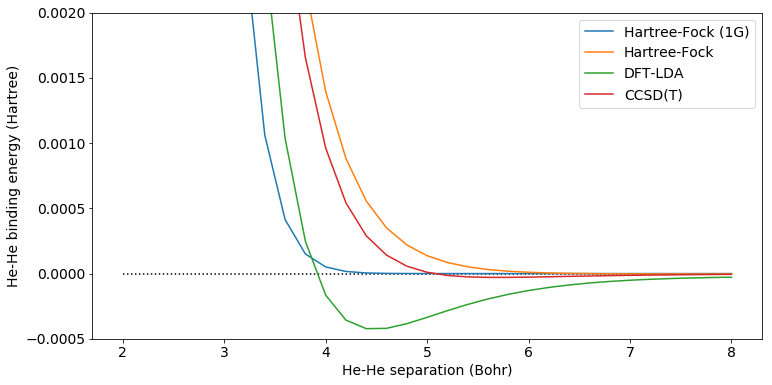

In [167]:
# more lazy shorthand functions
def w1(): return 0.5/np.sqrt(1.0 + AB()) + 0.5/np.sqrt(1.0 - AB())
def w2(): return 0.5/np.sqrt(1.0 + AB()) - 0.5/np.sqrt(1.0 - AB())

def dimer_energy1(distance, width):
    global d0, r0
    d0 = distance
    r0 = width
    return (4.0*(w1()**2 + w2()**2)*(h_AA() + vA_AA() + vB_AA())
            + 8.0*w1()*w2()*(h_AB() + 2.0*vA_AB()))

def dimer_energy2H(distance, width):
    global d0, r0
    d0 = distance
    r0 = width
    return (4.0*(w1()**2 + w2()**2)**2*AAAA() + 4.0*(w1()**2 + w2()**2)**2*AABB()
            + 32.0*(w1()**3*w2()+w1()*w2()**3)*AAAB() + 32.0*w1()**2*w2()**2*ABAB())

def dimer_energy2X(distance, width):
    global d0, r0
    d0 = distance
    r0 = width
    return -(2.0*(w1()**2 + w2()**2)**2*AAAA() + 8.0*w1()**2*w2()**2*AABB()
             + 16.0*(w1()**3*w2()+w1()*w2()**3)*AAAB() + 2.0*((w1()**2+w2()**2)**2+4.0*w1()**2*w2()**2)*ABAB())

def dimer_energy(distance, width):
    global d0, r0
    d0 = distance
    r0 = width
    return E_ion() + dimer_energy1(d0, r0) + dimer_energy2H(d0, r0) + dimer_energy2X(d0, r0)

dimer_list = [dimer_energy(distance, width) - 2.0*atom_energy(width) for distance in distance_list]
plt.plot(distance_list, [0] * len(distance_list), linestyle=':', color='black')
plt.plot(distance_list, dimer_list, label='Hartree-Fock (1G)')
plt.plot(distance_list, hf_energy_list, label='Hartree-Fock')
plt.plot(distance_list, lda_energy_list, label='DFT-LDA')
plt.plot(distance_list, ref_energy_list, label='CCSD(T)')

plt.xlabel('He-He separation (Bohr)')
plt.ylabel('He-He binding energy (Hartree)')
plt.legend()

plt.ylim(-0.0005,0.002)
plt.show()

In terms of the binding energy that ignores the large error in the isolated He atom, the single-Gaussian approximation looks surprisingly good relative to DFT-LDA. It retains a purely repulsive energy of the basis-converged result, and it distorts the onset of repulsion not much worse than DFT-LDA.

The most important MNDO model approximation for reducing the cost of electronic structure approximations is the neglect of diatomic differential overlap (NDDO). The NDDO approximation ignores Coulomb integrals when they contain a product of atomic orbitals on two different centers and approximates the remaining integrals with the non-orthogonal basis functions, resulting in the approximations

$$ \begin{align}
 \tilde{E}_{2H} &= 4 (A A | A A ) + 4 ( A A | B B ) \\
 \tilde{E}_{2X} &= -2 (A A | A A ) .
\end{align} $$

This approximation can be justified by considering an atom-centered multipole expansion of Coulomb integrals. Both orthogonal and non-orthogonal orbitals are normalized and form a unit monopole with themselves. Pairs of orthogonal orbitals do not produce a monopole term because of their orthogonality. Thus all Coulomb integrals containing products of orthogonal orbitals from different sites vanish at the monopole level of a multipole expansion. Most NDDO-based models expand the remaining on-site Coulomb integrals to the dipole or quadrupole level of multipole expansion (or else use Coulomb integrals directly from a higher level of theory). The final on-site replacement of orthogonalized orbitals with non-orthogonal orbitals is somewhat justified by assuming that the orthogonalization effects caused by an atom's "chemical environment" cancel out on average. Furthermore, the reparameterization of constant (i.e. interatomic potentials) and one-body terms in the model Hamiltonian help to compensate for the effects of the NDDO approximation.

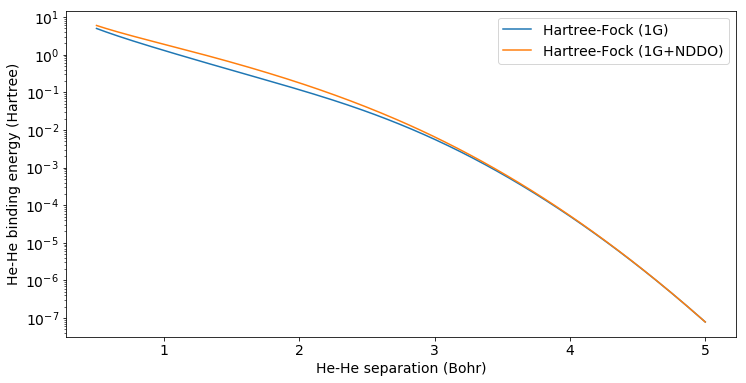

In [192]:
def dimer_energy2H_nddo(distance, width):
    global d0, r0
    d0 = distance
    r0 = width
    return 4.0*AAAA() + 4.0*AABB()

def dimer_energy2X_nddo(distance, width):
    global d0, r0
    d0 = distance
    r0 = width
    return -2.0*AAAA()

def dimer_energy_nddo(distance, width):
    global d0, r0
    d0 = distance
    r0 = width
    return E_ion() + dimer_energy1(d0, r0) + dimer_energy2H_nddo(d0, r0) + dimer_energy2X_nddo(d0, r0)

dimer_list = [dimer_energy(distance, width) - 2.0*atom_energy(width) for distance in distance_list2]
nddo_list = [dimer_energy_nddo(distance, width) - 2.0*atom_energy(width) for distance in distance_list2]
plt.semilogy(distance_list2, dimer_list, label='Hartree-Fock (1G)')
plt.semilogy(distance_list2, nddo_list, label='Hartree-Fock (1G+NDDO)')

plt.xlabel('He-He separation (Bohr)')
plt.ylabel('He-He binding energy (Hartree)')
plt.legend()

plt.show()

NDDO errors become noticeable for small interatomic distances, but the NDDO approximation is able to retain the overall repulsion of HF theory and maintain good relative accuracy in the binding energy. This is easy to understand within our single-Gaussian model: the NDDO errors are all second order in the interatomic overlap, $\langle A|B\rangle$.

Before continuing our error analysis, let us more closely resolve the source of repulsion between He atoms by separating the kinetic energy from the other HF energy contributions:

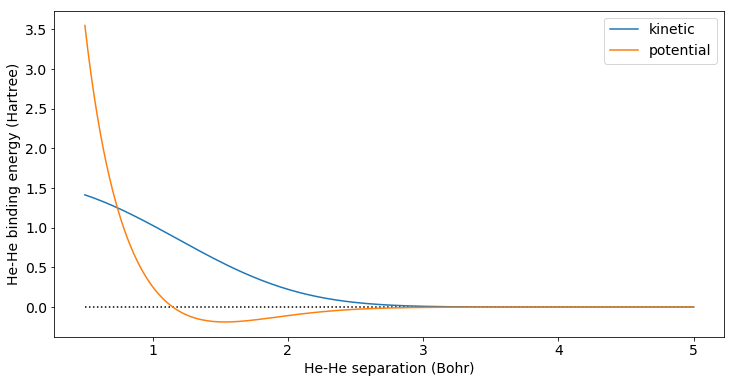

In [189]:
def dimer_kinetic(distance, width):
    global d0, r0
    d0 = distance
    r0 = width
    return 4.0*(w1()**2 + w2()**2)*h_AA() + 8.0*w1()*w2()*h_AB()

kinetic_list = [dimer_kinetic(distance, width) - dimer_kinetic(max_distance, width) for distance in distance_list2]
potential_list = [dimer_energy(distance, width) - dimer_kinetic(distance, width) -
                  (dimer_energy(max_distance, width) - dimer_kinetic(max_distance, width))
                  for distance in distance_list2]

plt.plot(distance_list2, [0] * len(distance_list2), linestyle=':', color='black')
plt.plot(distance_list2, kinetic_list, label='kinetic')
plt.plot(distance_list2, potential_list, label='potential')

plt.xlabel('He-He separation (Bohr)')
plt.ylabel('He-He binding energy (Hartree)')
plt.legend()

plt.show()

Here is where we encounter the single largest problem with MNDO-based models. All of the "potential" contributions to HF-like energies that originate from the Coulomb interaction have a short-ranged repulsion and an intermediate-ranged attraction, which is the natural result of the Coulomb interaction between two clouds of charge, each with a central positive point charge and a broader neutralizing distribution of negative charge. The repulsion between closed-shell clusters must then come from the increase in kinetic energy caused by orthogonalization pressure as the occupied orbitals of two clusters are pushed closer together. However, MNDO-based models perform their mean-field calculations directly in an orthogonal basis with a restricted form that is incapable of capturing the effects of orthogonalization in the correct place.

Specifically, the MNDO kinetic energy matrix of a He dimer will have the form

$$ \mathbf{H} = \begin{bmatrix} E & t \\ t & E \end{bmatrix} $$

in the orthogonal basis and the kinetic energy will be twice its trace, $2\mathrm{tr}(\mathbf{H}) = 4 E$. The hopping matrix element $t$ will be distance-dependent, but the on-site energy $E$ is a constant atomic property. Thus, the kinetic energy term does not provide the necessary repulsion and does not contribute to the He dimer binding energy at all. This wouldn't be a problem if the mean-field calculations were performed in the original non-orthogonal atomic orbital basis, where the kinetic energy includes the overlap matrix $\mathbf{S}$ explicitly,

$$ \mathbf{S} = \begin{bmatrix} 1 & \langle A | B \rangle \\ \langle A | B \rangle & 1 \end{bmatrix} \\
   E_{\mathrm{kin}} = 2 \mathrm{tr}(\mathbf{S}^{-1} \mathbf{H} ) = 4 \frac{E - t \langle A | B \rangle}{1 - \langle A | B \rangle^2 } .
$$

Since $t$ is proportional to the overlap, the orthogonalization correction to the kinetic energy is strictly $O(\langle A | B \rangle^2)$ like many other modest NDDO errors. However, $t$ also has a prefactor that is quadratic in the interatomic distance, which strongly enhances its effect in practice over NDDO errors.

If the MNDO-based models had built an accurate approximation to $\mathbf{S}^{-1/2} \mathbf{H} \mathbf{S}^{-1/2}$ as their one-body Hamiltonians, then there wouldn't have been any problems with defining the model and performing calculations directly in an orthogonal basis. This complicates the distance-dependence of the hopping parameter and requires an effective short-ranged repulsive potential to modify the on-site energy. However, the lack of repulsion in total energies was corrected as an added interatomic potential rather than an electronic potential. Its effect on the total energy is not modulated by the number of electrons on an atom, and in turn it is unable to modulate the distribution of electrons. By correcting this problem in the wrong place, MNDO-based semiempirical models have artificially limited their transferability and ability to fit data without introducing increasingly complicated interatomic potential corrections. Since most of the data being fit by these models are total energies (or total energy differences) rather than electronic properties, they could be improved by keeping the electronic parameters fixed and continuing to add complexity and parameters to their interatomic potentials.

The closest physics equivalent to semiempirical quantum chemistry models are tight-binding models, which have historically been used to fit the electronic band structures of crystals. In physics lore, non-orthogonal basis sets are strongly recommended for solid-state tight-binding models to improve their transferability. For our simple example, the analytical form of the one-body Hamiltonian is complicated by orthogonalization,

$$ \begin{align} \mathbf{S}^{-1/2} \mathbf{H} \mathbf{S}^{-1/2} &= \begin{bmatrix} E' & t' \\ t' & E' \end{bmatrix}^{1/2} \\
 E' &= \frac{E - t \langle A | B \rangle}{1 - \langle A | B \rangle^2 } \\
 t' &= \frac{t - E \langle A | B \rangle}{1 - \langle A | B \rangle^2 } \end{align} $$
 
but its actual distance-dependence does not become substantially more complicated with only two atoms:

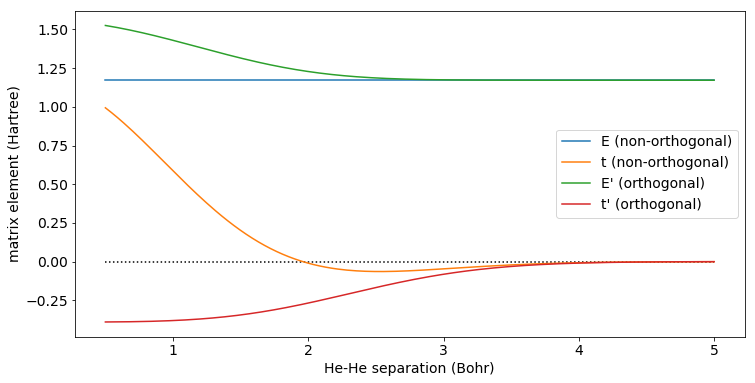

In [195]:
E_list = [kinetic(0.0, width) for distance in distance_list2]
t_list = [kinetic(distance, width) for distance in distance_list2]

E_list2 = [(kinetic(0.0, width) - kinetic(distance, width)*overlap(distance, width))/
          (1.0 - overlap(distance, width)**2) for distance in distance_list2]
t_list2 = [(kinetic(distance, width) - kinetic(0.0, width)*overlap(distance, width))/
          (1.0 - overlap(distance, width)**2) for distance in distance_list2]

plt.plot(distance_list2, [0] * len(distance_list2), linestyle=':', color='black')
plt.plot(distance_list2, E_list, label='E (non-orthogonal)')
plt.plot(distance_list2, t_list, label='t (non-orthogonal)')
plt.plot(distance_list2, E_list2, label="E' (orthogonal)")
plt.plot(distance_list2, t_list2, label="t' (orthogonal)")

plt.xlabel('He-He separation (Bohr)')
plt.ylabel('matrix element (Hartree)')
plt.legend()

We can conclude from this analysis that the single largest error in MNDO model approximations is the use of interatomic potentials rather than electronic potentials to correct for missing interatomic repulsion. This error is detrimental to the transferability of these models, and it persists in many popular models to the present day. In contrast, the NDDO approximation of two-body matrix elements is more well-behaved and does not cause any significant problems for the repulsion between closed-shell objects. The effects of NDDO errors become appreciable for systems with covalent bonds.

NOTE: The single-Gaussian HF calculations were tested against equivalent reference calculations performed in Psi4. They were a bit of a messy hack, thus I did not include them directly in this Jupyter notebook.